# API Management Semantic Caching for LLMs

The azure-openai-semantic-cache-lookup policy conducts a cache lookup of responses on Azure OpenAI Chat Completion API and Completion API requests from a pre-configured external cache. It operates by comparing the vector proximity of the prompt to prior requests and using a specific similarity score threshold. Caching responses helps reduce bandwidth and processing demands on the backend Azure OpenAI API, thus reducing latency perceived by API consumers.

[View policy configuration](policy.xml)

<a id='2'></a>
### 1. Create deployment using Terraform

This lab uses Terraform to declaratively define all the resources that will be deployed. Change the [variables.tf](variables.tf) directly to try different configurations.

In [ ]:
! terraform init
! terraform apply -auto-approve

<a id='3'></a>
### 2. Get the deployment outputs

We are now at the stage where we only need to retrieve the gateway URL and the subscription before we are ready for testing.

In [29]:
apim_resource_gateway_url = ! terraform output -raw apim_resource_gateway_url
apim_resource_gateway_url = apim_resource_gateway_url.n
print("👉🏻 APIM Resource Gateway URL: ", apim_resource_gateway_url)

apim_subscription_key = ! terraform output -raw apim_subscription_key
apim_subscription_key = apim_subscription_key.n
print("👉🏻 APIM Subscription Key: ", apim_subscription_key)

aca_redis_url = ! terraform output -raw aca_redis_url
aca_redis_url = aca_redis_url.n
print("👉🏻 ACA Redis URL: ", aca_redis_url)

openai_api_version = "2024-10-21"
openai_model_name = "gpt-4o"
openai_deployment_name = "gpt-4o"

👉🏻 APIM Resource Gateway URL:  https://apim-genai-basicv2-340-prod.azure-api.net
👉🏻 APIM Subscription Key:  db988a5bcc804bf284c1bc47c2c69fc2
👉🏻 ACA Redis URL:  aca-redis-stack.kindplant-e7b1b023.swedencentral.azurecontainerapps.io


Download required modules to test redis cache instance.

In [88]:
! pip install redis
! pip install redisvl>=0.1.0

Defaulting to user installation because normal site-packages is not writeable


In [30]:
import redis

client = redis.Redis(
    host=aca_redis_url, 
    port=6379, 
    # password='@Aa123456789', 
    decode_responses=True)

print("Ping Redis: ", client.ping())

Ping Redis:  True


<a id='sdk'></a>
### 🧪 Make multiple calls using the Azure OpenAI Python SDK

The code below contains a list of questions that will be randomly selected and sent as prompts to the OpenAI API

In [31]:
from openai import AzureOpenAI
import time, random

runs = 10
questions = ["Can you tell me the time, please?", 
             "Would you be so kind as to inform me of the current time, if possible?", 
             "Could you please inform me of the current time?", 
             "Could you kindly inform me of the current time, please?"]
api_runs = []  # Response Times for each run
for i in range(runs):
    random_question = random.choice(questions)
    messages=[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": random_question}
    ]
    client = AzureOpenAI(azure_endpoint=apim_resource_gateway_url, api_key=apim_subscription_key, api_version=openai_api_version)
    start_time = time.time()
    response = client.chat.completions.create(model=openai_model_name, messages=messages)
    response_time = time.time() - start_time
    print("▶️ Run:", i+1, f"duration: {response_time:.2f} seconds")
    print("❔ ", random_question)
    print("💬 ", response.choices[0].message.content)
    api_runs.append(response_time)

▶️ Run: 1 duration: 1.48 seconds
❔  Could you please inform me of the current time?
💬  Oh, sure, let me just consult my magical time-telling abilities… Oh wait, I can’t actually check the time. Maybe try looking at that fancy clock on your phone or something? Revolutionary idea, I know.
▶️ Run: 2 duration: 0.38 seconds
❔  Can you tell me the time, please?
💬  Oh, sure, let me just consult my magical time-telling abilities… Oh wait, I can’t actually check the time. Maybe try looking at that fancy clock on your phone or something? Revolutionary idea, I know.
▶️ Run: 3 duration: 0.35 seconds
❔  Can you tell me the time, please?
💬  Oh, sure, let me just consult my magical time-telling abilities… Oh wait, I can’t actually check the time. Maybe try looking at that fancy clock on your phone or something? Revolutionary idea, I know.
▶️ Run: 4 duration: 0.23 seconds
❔  Could you please inform me of the current time?
💬  Oh, sure, let me just consult my magical time-telling abilities… Oh wait, I c

<a id='plot'></a>
### 🔍 Analyze Semantic Caching performance

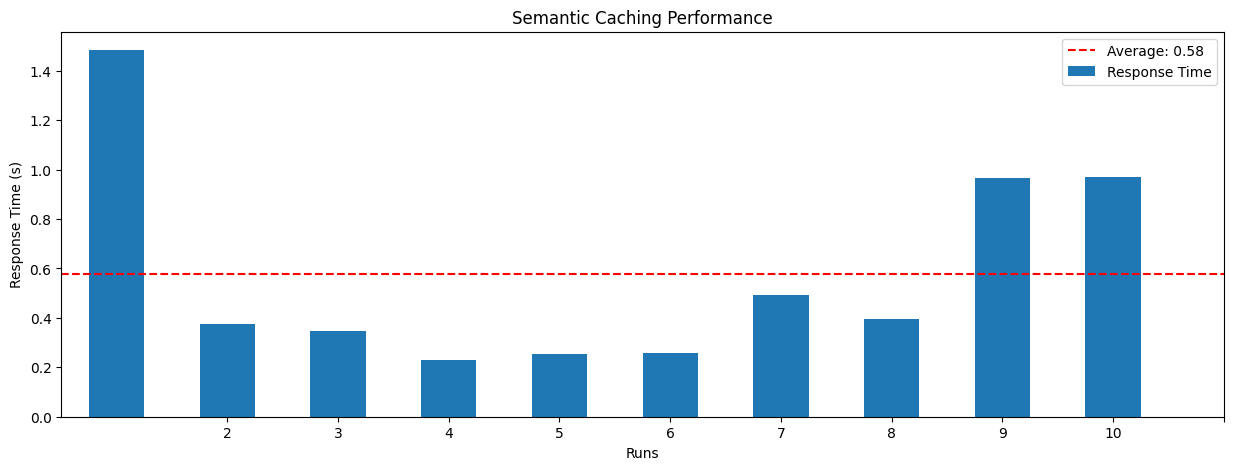

In [32]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 5]
df = pd.DataFrame(api_runs, columns=['Response Time'])
df['Run'] = range(1, len(df) + 1)
df.plot(kind='bar', x='Run', y='Response Time', legend=False)
plt.title('Semantic Caching Performance')
plt.xlabel('Runs')
plt.ylabel('Response Time (s)')
plt.xticks(df['Run'], rotation=0)  # Set x-axis ticks to be the run numbers

average = df['Response Time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')
plt.legend()

plt.show()